### Import necessary modules

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

2024-02-27 21:38:12.767820: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 21:38:16.391713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 21:38:16.402813: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 21:38:30.290928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read poem txt file

In [2]:
with open('irish_lyrics.txt','r') as f:
    data = f.read()
print(type(data))

<class 'str'>


### Tokenization

In [3]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)
corpus

2690


['come all ye maidens young and fair',
 'and you that are blooming in your prime',
 'always beware and keep your garden fair',
 'let no man steal away your thyme',
 'for thyme it is a precious thing',
 'and thyme brings all things to my mind',
 'nlyme with all its flavours, along with all its joys',
 'thyme, brings all things to my mind',
 'once i and a bunch of thyme',
 'i thought it never would decay',
 'then came a lusty sailor',
 'who chanced to pass my way',
 'and stole my bunch of thyme away',
 'the sailor gave to me a rose',
 'a rose that never would decay',
 'he gave it to me to keep me reminded',
 'of when he stole my thyme away',
 'sleep, my child, and peace attend thee',
 'all through the night',
 'guardian angels god will send thee',
 'soft the drowsy hours are creeping',
 'hill and dale in slumber sleeping',
 'i my loving vigil keeping',
 'while the moon her watch is keeping',
 'while the weary world is sleeping',
 'oer thy spirit gently stealing',
 'visions of delight rev

### Sequencing

In [4]:
sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)
sequences

[[51, 12],
 [51, 12, 96],
 [51, 12, 96, 1217],
 [51, 12, 96, 1217, 48],
 [51, 12, 96, 1217, 48, 2],
 [51, 12, 96, 1217, 48, 2, 69],
 [2, 11],
 [2, 11, 15],
 [2, 11, 15, 31],
 [2, 11, 15, 31, 361],
 [2, 11, 15, 31, 361, 8],
 [2, 11, 15, 31, 361, 8, 24],
 [2, 11, 15, 31, 361, 8, 24, 1218],
 [272, 798],
 [272, 798, 2],
 [272, 798, 2, 204],
 [272, 798, 2, 204, 24],
 [272, 798, 2, 204, 24, 579],
 [272, 798, 2, 204, 24, 579, 69],
 [118, 35],
 [118, 35, 119],
 [118, 35, 119, 799],
 [118, 35, 119, 799, 56],
 [118, 35, 119, 799, 56, 24],
 [118, 35, 119, 799, 56, 24, 184],
 [10, 184],
 [10, 184, 25],
 [10, 184, 25, 23],
 [10, 184, 25, 23, 5],
 [10, 184, 25, 23, 5, 580],
 [10, 184, 25, 23, 5, 580, 456],
 [2, 184],
 [2, 184, 800],
 [2, 184, 800, 12],
 [2, 184, 800, 12, 801],
 [2, 184, 800, 12, 801, 4],
 [2, 184, 800, 12, 801, 4, 7],
 [2, 184, 800, 12, 801, 4, 7, 235],
 [1219, 17],
 [1219, 17, 12],
 [1219, 17, 12, 75],
 [1219, 17, 12, 75, 1220],
 [1219, 17, 12, 75, 1220, 236],
 [1219, 17, 12, 75, 1

### Padding

In [5]:
max_sequence_len = max([len(i) for i in sequences])
max_sequence_len

16

In [6]:
sequences = pad_sequences(sequences, padding = 'pre', maxlen = max_sequence_len)
sequences = np.array(sequences)
sequences

array([[   0,    0,    0, ...,    0,   51,   12],
       [   0,    0,    0, ...,   51,   12,   96],
       [   0,    0,    0, ...,   12,   96, 1217],
       ...,
       [   0,    0,    0, ...,    0,   47,  105],
       [   0,    0,    0, ...,   47,  105,  138],
       [   0,    0,    0, ...,  105,  138,  184]], dtype=int32)

### Labelling

We can take the last elements as labels and the other to be x

In [7]:
x = sequences[:, :-1]
labels = sequences[:, -1:]
labels

array([[  12],
       [  96],
       [1217],
       ...,
       [ 105],
       [ 138],
       [ 184]], dtype=int32)

### One-hot encoding labels

In [8]:
y = tf.keras.utils.to_categorical(labels, num_classes = total_words)
print(y[0][9:15])
print(y[1][93:99])
y[2][1217]

[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0.]


1.0

### Build model

In [9]:
model = Sequential()
# we use max_sequence_len -1 because we used the last element as label
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation = 'softmax'))
adam = Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Train model

In [10]:
history = model.fit(x, y, epochs=100, verbose=1)

2024-02-27 21:38:57.616615: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129528880 exceeds 10% of free system memory.


Epoch 1/100
377/377 [==============================] - 41s 95ms/step - loss: 6.6509 - accuracy: 0.0744
Epoch 2/100
377/377 [==============================] - 38s 100ms/step - loss: 5.7595 - accuracy: 0.1146
Epoch 3/100
377/377 [==============================] - 38s 99ms/step - loss: 4.9331 - accuracy: 0.1616
Epoch 4/100
377/377 [==============================] - 34s 91ms/step - loss: 4.4385 - accuracy: 0.2073
Epoch 5/100
377/377 [==============================] - 30s 80ms/step - loss: 5.1502 - accuracy: 0.1930
Epoch 6/100
377/377 [==============================] - 30s 79ms/step - loss: 3.6171 - accuracy: 0.2870
Epoch 7/100
377/377 [==============================] - 32s 86ms/step - loss: 2.9421 - accuracy: 0.3685
Epoch 8/100
377/377 [==============================] - 38s 101ms/step - loss: 2.5279 - accuracy: 0.4335
Epoch 9/100
377/377 [==============================] - 38s 101ms/step - loss: 2.2020 - accuracy: 0.4941
Epoch 10/100
377/377 [==============================] - 36s 96ms/step 

377/377 [==============================] - 39s 103ms/step - loss: 1.0946 - accuracy: 0.7421
Epoch 80/100
377/377 [==============================] - 41s 110ms/step - loss: 1.2020 - accuracy: 0.7170
Epoch 81/100
377/377 [==============================] - 41s 109ms/step - loss: 1.1856 - accuracy: 0.7193
Epoch 82/100
377/377 [==============================] - 38s 99ms/step - loss: 1.1657 - accuracy: 0.7193
Epoch 83/100
377/377 [==============================] - 31s 82ms/step - loss: 1.0940 - accuracy: 0.7381
Epoch 84/100
377/377 [==============================] - 32s 84ms/step - loss: 1.0181 - accuracy: 0.7567
Epoch 85/100
377/377 [==============================] - 33s 89ms/step - loss: 0.9703 - accuracy: 0.7685
Epoch 86/100
377/377 [==============================] - 33s 88ms/step - loss: 0.9984 - accuracy: 0.7583
Epoch 87/100
377/377 [==============================] - 33s 88ms/step - loss: 1.0366 - accuracy: 0.7505
Epoch 88/100
377/377 [==============================] - 35s 93ms/step - lo

### Plot graphs

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

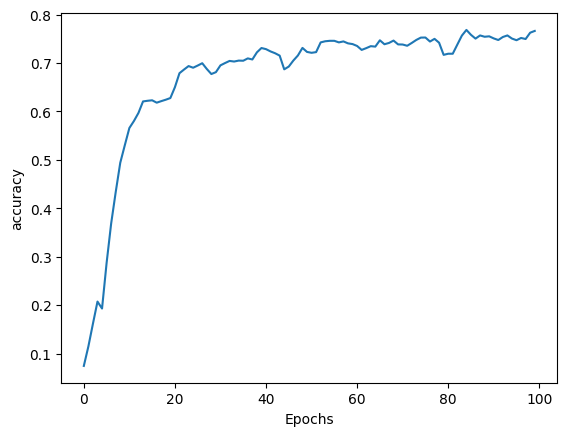

In [20]:
plot_graphs(history, 'accuracy')

### Generate text

In [32]:
seed_text1 = "I made a poetry machine"
seed_text2 = "I've got a bad feeling about this"
next_words = 100

def generate_text(model, seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
        predicted = np.argmax(model.predict(token_list, verbose = 0))
        output_word = ""
    
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text
    
result = generate_text(model, seed_text2, 15)
print(result)

I've got a bad feeling about this narrow thady thee i for to play the same though you gave brightly i must


### Saving model

In [65]:
import os
export_path = os.path.join("saved_models", "create_poetry.h5")
export_path_updated = os.path.join("saved_models", "create_poetry_updated.h5")

model.save(export_path)

In [68]:
!ls 

create_poetry.ipynb  recognize_sentiment_sarcasm.ipynb	Tokenization.ipynb
irish_lyrics.txt     saved_models


### Load saved model

In [69]:
reloaded = tf.keras.models.load_model(export_path_updated)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 240)           645600    
                                                                 
 bidirectional (Bidirection  (None, 300)               469200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1924490 (7.34 MB)
Trainable params: 1924490 (7.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Check reloaded model

In [70]:
seed_text1 = "I made a poetry machine"
seed_text2 = "I've got a bad feeling about this"
next_words = 15

results = generate_text(reloaded, seed_text, next_words)
print(results)

I've got a bad feeling about this narrow drinking not to but never would not they say theres bread beguiled the good


### Keep Training

In [71]:
EPOCHS = 5
reloaded_history = reloaded.fit(x, y, epochs = EPOCHS, verbose = 1)

Epoch 1/5


2024-02-27 23:03:53.474513: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129528880 exceeds 10% of free system memory.


377/377 [==============================] - 36s 88ms/step - loss: 0.9571 - accuracy: 0.7760
Epoch 2/5
377/377 [==============================] - 33s 88ms/step - loss: 0.9720 - accuracy: 0.7658
Epoch 3/5
377/377 [==============================] - 33s 88ms/step - loss: 0.9969 - accuracy: 0.7618
Epoch 4/5
377/377 [==============================] - 33s 88ms/step - loss: 1.0230 - accuracy: 0.7515
Epoch 5/5
377/377 [==============================] - 33s 88ms/step - loss: 1.0373 - accuracy: 0.7482


In [73]:
reloaded.save(export_path_updated)

### Export as SavedModel

In [90]:
export_path = "saved_models/create_poetry_sm"

tf.saved_model.save(model, export_path)

INFO:tensorflow:Assets written to: saved_models/create_poetry_sm/assets


INFO:tensorflow:Assets written to: saved_models/create_poetry_sm/assets


In [91]:
!ls {export_path}

assets	fingerprint.pb	saved_model.pb	variables


### Load SavedModel

In [92]:
reloaded_sm = tf.saved_model.load(export_path)

In [82]:
results = generate_text(reloaded_sm, seed_text, 10)
print(results)

AttributeError: '_UserObject' object has no attribute 'predict'

### Loading the SavedModel as a Keras model

In [93]:
reload_sm = tf.keras.models.clone_model(reloaded_sm)

export_path = "saved_models/cloned_create_poetry_sm"
tf.saved_model.save(reload_sm, export_path)

AttributeError: type object '_UserObject' has no attribute 'from_config'

In [89]:
reloaded_sm_keras = tf.keras.models.load_model(export_path)
reloaded_sm_keras.summary()

ValueError: Unable to create a Keras model from SavedModel at saved_models/cloned_create_poetry_sm. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.